In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()


# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml inference_config

experiment:
    exp_root: '?'
    seed: 42

data:
    splits: ('val', 'cal')
    preload: False 

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

log:
    root: '?'
    log_interval: 10 
    show_examples: False 
    log_image_stats: True 
    log_pixel_stats: True
    min_fg_pixels: 0 
    track_ensemble_member_scores: True
    summary_compute_global_metrics: True

<IPython.core.display.Javascript object>

In [3]:
%%yaml model_cfg

model:
    calibrator: '?'
    checkpoint: '?' 
    ensemble: '?' 
    ensemble_cfg: '?'
    ensemble_w_metric: '?'
    pretrained_exp_root : '?' 
    normalize: False 
    cal_stats_split: "val"
    pretrained_select_metric: "val-dice_score"

<IPython.core.display.Javascript object>

In [4]:
from typing import List, Optional
from ese.scripts.utils import gather_exp_paths


def get_ese_inference_configs(
    group_dict: dict,
    calibrators_list: List[str], 
    do_ensemble: bool = False, 
    log_image_stats: bool = True,
    log_pixel_stats: bool = True,
    show_examples: bool = False,
    ensemble_upper_bound: bool = False,
    normalize_opts: Optional[List[bool]] = None,
    cal_stats_splits: Optional[List[str]] = None,
    additional_args: Optional[dict] = None,
    ens_cfg_options: Optional[List[tuple]] = None,
    ens_w_metric_list: Optional[List[str]] = ['None'],
):
    if not do_ensemble:
        assert ens_w_metric_list == ['None'], "No weighting can be provided if no ensemble."
        assert ens_cfg_options == None, "No ensemble config can be provided if no ensemble."
        assert not ensemble_upper_bound, "No ensemble upper bound can be provided if no ensemble."

    if ens_cfg_options is None:
        ens_cfg_options = [None]

    calibrator_option_list = []
    for calibrator in calibrators_list:
        for ensemble_w_metric in ens_w_metric_list:
            if "Binning" in calibrator:
                iter_norm_opts = normalize_opts
                iter_calsplit_opts = cal_stats_splits
            else:
                iter_norm_opts = [False]
                iter_calsplit_opts = [None]
            # Iterate over the different normalization options, only really used if doing a binning calibrator.
            for norm in iter_norm_opts:
                for cal_stats_split in iter_calsplit_opts:
                    # Define the paths for the uncailbrated networks.
                    ##################################################
                    if (calibrator == "Uncalibrated") or ("Binning" in calibrator):
                        ensemble_root = f"/storage/vbutoi/scratch/ESE/training/{group_dict['base_models_group']}"
                        checkpoint = "max-val-dice_score" 
                    # Define the paths for the calibrated networks.
                    ##################################################
                    else:
                        ensemble_root = f"/storage/vbutoi/scratch/ESE/calibration/{group_dict['calibrated_models_group']}/Individual_{calibrator}"
                        checkpoint = "min-val-ece_loss"

                    # Set a few things that will be consistent for all runs.
                    ##################################################
                    exp_root = root / "inference" / group_dict['exp_group']

                    # Get the calibrator name
                    calibrator_class_name_map = {
                        "TempScaling": "ese.experiment.models.calibrators.Temperature_Scaling",
                        "VectorScaling": "ese.experiment.models.calibrators.Vector_Scaling",
                        "DirichletScaling": "ese.experiment.models.calibrators.Dirichlet_Scaling",
                        "LTS": "ese.experiment.models.calibrators.LTS",
                        "NectarScaling": "ese.experiment.models.calibrators.NECTAR_Scaling",
                        "HistogramBinning": "ese.experiment.models.calibrators.Histogram_Binning",
                        "NectarBinning": "ese.experiment.models.calibrators.NECTAR_Binning",
                    }
                    if calibrator in calibrator_class_name_map:
                        calibrator_cls = calibrator_class_name_map[calibrator]
                    else:
                        calibrator_cls = calibrator

                    default_config_options = {
                        'experiment.exp_root': [str(exp_root)],
                        'experiment.dataset_name': [group_dict['dataset']],
                        'model.checkpoint': [checkpoint],
                        'model.calibrator': [calibrator],
                        'model.calibrator_cls': [calibrator_cls],
                        'model.normalize': [norm],
                        'model.cal_stats_split': [cal_stats_split],
                        'data.preload': [group_dict['preload']],
                        'log.show_examples': [show_examples],
                        'log.log_image_stats': [log_image_stats],
                        'log.log_pixel_stats': [log_pixel_stats],
                    }

                    if additional_args is not None:
                        default_config_options.update(additional_args)
                    # Make presets for the different runnning configurations.
                    ##################################################
                    # If you want to run inference on ensembles, use this.
                    if do_ensemble:
                        if ensemble_upper_bound:
                            log_root = str(exp_root / f"ensemble_upper_bounds")
                        else:
                            log_root = str(exp_root / f"{group_dict['dataset']}_Ensemble_{calibrator}")
                        advanced_args = {
                            'log.root': [log_root],
                            'model.pretrained_exp_root': [ensemble_root],
                            'model.ensemble': [True],
                            'model.ensemble_w_metric': [ensemble_w_metric],
                            'model.ensemble_cfg': ens_cfg_options 
                        }
                    # If you want to run inference on individual networks, use this.
                    else:
                        advanced_args = {
                            'log.root': [str(exp_root / f"{group_dict['dataset']}_Individual_{calibrator}")],
                            'model.pretrained_exp_root': gather_exp_paths(ensemble_root), # Note this is a list of train exp paths.
                            'model.ensemble': [False],
                            'model.ensemble_cfg': ens_cfg_options,
                            'model.ensemble_w_metric': [None]
                        }
                    
                    if "Binning" in calibrator:
                        assert (exp_root / f"{group_dict['dataset']}_Individual_Uncalibrated").exists(),\
                            "Uncalibrated model inference results must exist for binning."

                    # Combine the default and advanced arguments.
                    default_config_options.update(advanced_args)
                    # Append these to the list of configs and roots.
                    calibrator_option_list.append(default_config_options)
    # Return the list of different configs.
    return calibrator_option_list

In [5]:
exp_name = '02_14_24_WMH_MinLabel' 
group_dict = {
    "dataset": "WMH",
    "exp_group": exp_name,
    "base_models_group": "01_08_24_WMH_Ensemble",
    "calibrated_models_group": "01_19_24_WMH_Foreground_Calibrators",
    "preload": False
}

# exp_name = '02_11_24_CityScapes_Inference' 
# group_dict = {
#     "dataset": "CityScapes",
#     "exp_group": exp_name,
#     "base_models_group": "01_25_24_CityScapes_Dice",
#     "calibrated_models_group": "01_26_24_CityScapes_Ensemble",
#     "preload": False
# }

### Standard Calibrators.

In [6]:
# Get the configs for the different runs.
dataset_options = get_ese_inference_configs(
    group_dict=group_dict,
    calibrators_list=[
        # 'Uncalibrated',
        # 'Vanilla',
        # 'TempScaling',
        # 'VectorScaling',
        # 'DirichletScaling',
        # 'LTS',
        'NectarScaling',
    ], 
    do_ensemble=True, 
    ens_cfg_options=[
        ('mean', 'logits'), 
        ('mean', 'probs'), 
        ('product', 'probs')
    ],
    ens_w_metric_list=[
        'None',
    ],
    show_examples=True
)

### Binning Calibrators

In [7]:
# # Get the configs for the different runs.
# dataset_options = get_ese_inference_configs(
#     group_dict=group_dict,
#     calibrators_list=[
#         # 'HistogramBinning',
#         'NectarBinning',
#     ], 
#     do_ensemble=True, 
#     ens_cfg_options=[
#         ('mean', 'logits'), 
#         ('mean', 'probs'), 
#         ('product', 'probs')
#     ],
#     ens_w_metric_list=[
#         'None',
#     ],
#     normalize_opts=[
#         True, 
#         False
#     ],
#     cal_stats_splits=[
#         'val',
#         'cal'
#     ],
#     show_examples=False
# )

### Upper Bounds

In [8]:
# # # Get the configs for computing the upepr bounds

# dataset_options = get_ese_inference_configs(
#     group_dict=group_dict,
#     do_ensemble=True, 
#     ensemble_upper_bound=True,
#     calibrators_list=[
#         'Uncalibrated',
#     ], 
#     ens_cfg_options=[
#         ('upperbound', 'probs')
#     ]
# )

In [9]:
from ese.scripts.utils import get_option_product
from ionpy.util import Config
import yaml

# Load the inference cfg from local.
##################################################
cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"
##################################################
with open(cfg_root / f"{group_dict['dataset']}.yaml", 'r') as file:
    dataset_inference_cfg = yaml.safe_load(file)
with open(cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)
##################################################
base_cfg = Config(inference_config).update([model_cfg, dataset_inference_cfg, cal_metrics_cfg])

# Get the configs
cfgs = get_option_product(exp_name, dataset_options, base_cfg)

In [10]:
len(cfgs)

3

## Running Jobs

In [11]:
from ese.experiment.analysis.run_inference import get_cal_stats

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Set seed: 42


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


  0%|          | 0/6 [00:00<?, ?it/s]

Set seed: 42
Set seed: 42


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 40
Set seed: 40
Set seed: 43
Set seed: 43
Set seed: 41
Set seed: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Set seed: 42
Running:

data:
  preload: false
  slicing: dense_full
  splits: ('val', 'cal')
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: ese.experiment.datasets.WMH
  annotator: observer_o12
  augmentations: null
  axis: 0
  num_slices: 1
  preload: false
  return_data_id: true
  slicing: dense_full
  task: Amsterdam
  version: 0.2
experiment:
  dataset_name: WMH
  exp_root: /storage/vbutoi/scratch/ESE/inference/02_14_24_WMH_MinLabel
  pretrained_seed: 42
  seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.ece.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.ece.edge_ece_loss
    cal_type: toplabel
- CW-ECE:
    _fn: ese.experiment.metrics.ece.cw_ece_loss
    cal_type: classwise
    class_weighting: proportional
- ECW-ECE:
    _fn: ese.experiment.metrics.ece.ecw_ece_loss
    cal_type: classwise
    class_weighting: proportional
- Uniform-CW-ECE:
    _fn: ese.experiment.metrics.ece.cw_ece_loss
    cal_ty

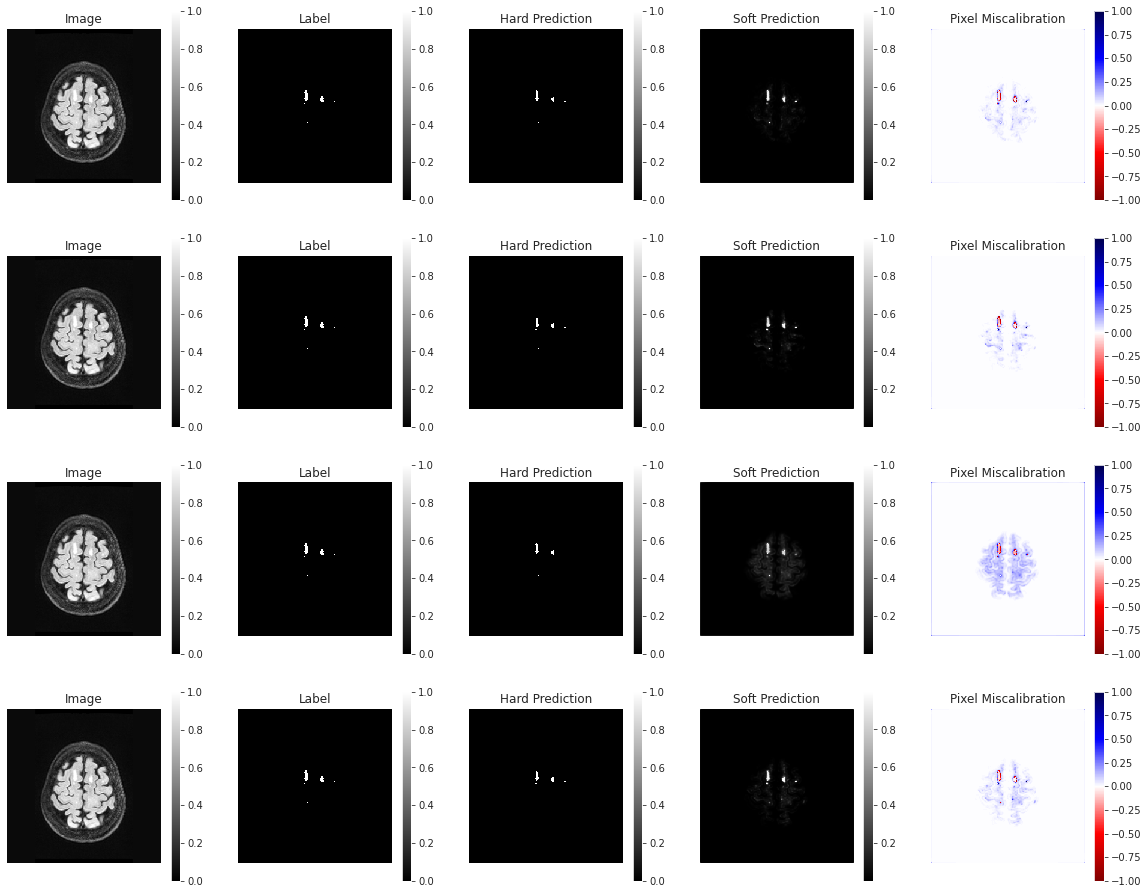

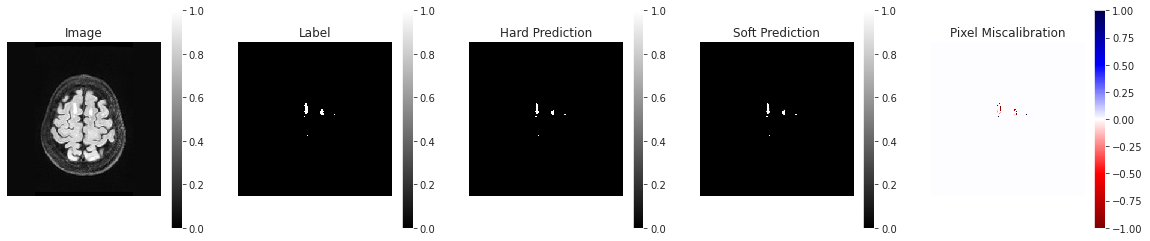

TypeError: unexpected keyword argument: 'from_logits'

In [12]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    gpu='3',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 
# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_cal_stats,
#     available_gpus=['0', '1', '2', '3']
#     # available_gpus=['4', '5', '6', '7']
# )

## Here we run upper-bounds.

In [ ]:
from ese.experiment.analysis.ensemble_upperbound import get_ensemble_ub

In [ ]:
# ###### Run individual jobs
# run_ese_exp(
#     config=cfgs[0], 
#     job_func=get_ensemble_ub,
#     run_name='debug',
#     gpu='0',
# ) 

In [ ]:
# ###### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_ensemble_ub,
#     available_gpus=['1']
# )